In [187]:
import PIL
import torchvision.transforms as transforms
import cv2
import math
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances

import pandas as pd
import matplotlib.pyplot as plt; import matplotlib.pylab as plt
import seaborn as sns
import pickle
import matplotlib.font_manager as fm
import matplotlib as mpl
import itertools

plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 15
methods = {'CORREL' :cv2.HISTCMP_CORREL, 'BHATTACHARYYA':cv2.HISTCMP_BHATTACHARYYA}

In [ ]:
import os
import pandas as pd
import numpy as np
from sympy import S
import torch.nn as nn
import torchsummary as summary
import torchvision
from tqdm import tqdm

from backbone import get_backbone_class
import backbone
from datasets.dataloader import get_labeled_episodic_dataloader
from io_utils import parse_args
from model import get_model_class
from model.classifier_head import get_classifier_head_class
from paths import get_output_directory, get_ft_output_directory, get_ft_train_history_path, get_ft_test_history_path, \
    get_final_pretrain_state_path, get_pretrain_state_path, get_ft_params_path
from utils import *

output_dir = 'CD-FSL/logs/baseline/output/torch_resnet18_simclr_LS_default/mini_test/05way_001shot_head_default'
torch_pretrained = ("torch" in "torch_resnet18")
print()
print('Running fine-tune with output folder:')
print(output_dir)
print()


n_shot = 1
s = 160 # 1(support shot) + 15(query shot) * 10(episode)
total_shot = 16

q = 0
w = 5

# Settings
n_episodes = 1 # to avoid overlapping, we sample all the imgs in 1 episode
n_epoch = 100

print()

# Dataloaders
# Note that both dataloaders sample identical episodes, via episode_seed
support_epochs = 1 
support_loader = get_labeled_episodic_dataloader('miniImageNet_test', n_way=w, n_shot=s, support=True,
                                                 n_query_shot=q, n_episodes=n_episodes, n_epochs=support_epochs,
                                                 #num_workers=params.num_workers,
                                                 split_seed=1, episode_seed=1)

support_iterator = iter(support_loader)

# use pretrained resnet 152 to extract features for analysis
feat_extract = torchvision.models.resnet152(pretrained = True)

# use pretrained resnet 18 to extract features for training
backbone = get_backbone_class("torch_resnet18")()



with torch.no_grad():
    x_support, _ = next(support_iterator)


Running fine-tune with output folder:
CD-FSL/logs/baseline/output/torch_resnet18_simclr_LS_default/mini_test/05way_001shot_head_default


End Preparing Sample Index


In [266]:
class0 = np.random.permutation(x_support[ 0 : s])
class1 = np.random.permutation(x_support[ s : 2*s])
class2 = np.random.permutation(x_support[ 2*s : 3*s])
class3 = np.random.permutation(x_support[ 3*s : 4*s])
class4 = np.random.permutation(x_support[ 4*s : 5*s])

# devide into 10 episodes
for i in tqdm(range(1)):
    class0_ep = class0[i * total_shot : (i+1) * total_shot]
    class1_ep = class1[i * total_shot : (i+1) * total_shot]
    class2_ep = class2[i * total_shot : (i+1) * total_shot]
    class3_ep = class3[i * total_shot : (i+1) * total_shot]
    class4_ep = class4[i * total_shot : (i+1) * total_shot]
    class_all_ep = np.stack([class0_ep, class1_ep, class2_ep, class3_ep, class4_ep], axis=0)

    sampled_support = class_all_ep[:, : n_shot].reshape(-1, 3, 224, 224)
    sampled_query = class_all_ep[: , n_shot:].reshape(-1, 3, 224, 224)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.35it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


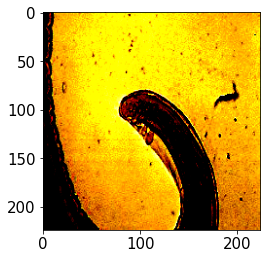

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


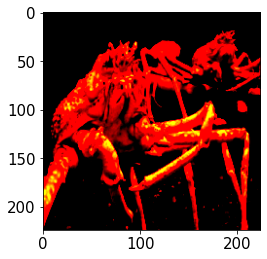

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


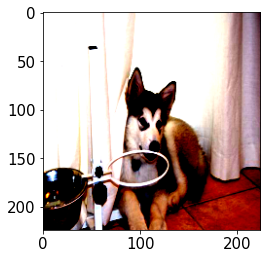

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


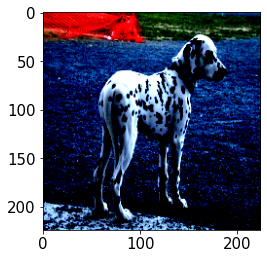

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


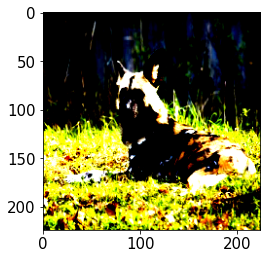

In [270]:
for i in range(w):
    plt.imshow(torch.Tensor(sampled_support[i]).cpu().permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


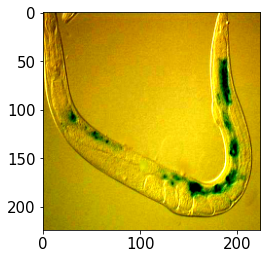

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


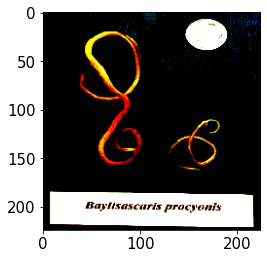

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


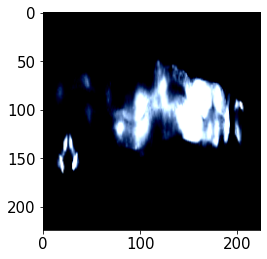

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


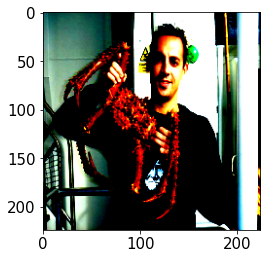

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


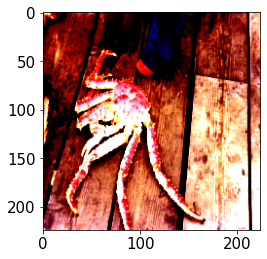

In [271]:
for i in range(w):
    plt.imshow(torch.Tensor(sampled_query[i+12]).cpu().permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


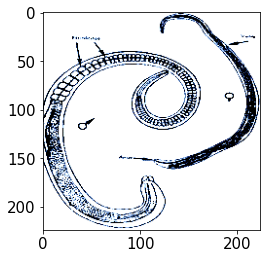

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


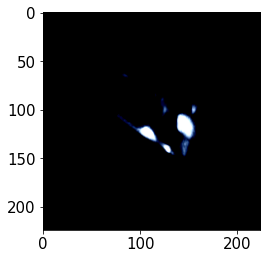

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


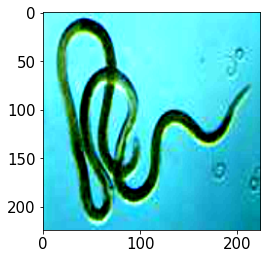

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


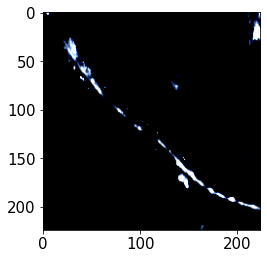

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


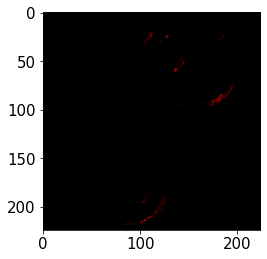

In [248]:
for i in range(w):
    plt.imshow(x_support[i+158].cpu().permute(1, 2, 0))
    plt.show()

## Cosine Similarity

### Use Pretrained 100 model

In [181]:
datas = ['mini_test', 'crop','euro', 'isic', 'chest']
name = ['best1', 'best2', 'best3', 'best4', 'best5', 'orst1', 'orst2', 'orst3', 'orst4', 'orst5']
df = pd.DataFrame(None, columns = name, index = datas)
for data in df.index: 
    for col in df.columns:
        path_support = './logs/img_ft_difference/feature/{}/pretrained/1shot/{}_x_support.npy'.format(data, col)
        path_query = './logs/img_ft_difference/feature/{}/pretrained/1shot/{}_x_query.npy'.format(data, col)
        f_s = np.load(path_support)
        f_q = np.load(path_query)
        sim = cosine_similarity(f_s, f_q)
        score = 0
        for cls in range(5):
            idx = cls * 15
            in_class = sim[:, idx:idx+15]
            for i in range(15):
                support = in_class[:,i]
                score = score + support[cls]/np.sum(np.delete(support, 1))
        df.loc[data,col] = math.exp(score)
df.columns = ['best1', 'best2', 'best3', 'best4', 'best5', 'worst1', 'worst2', 'worst3', 'worst4', 'worst5']
df

,best1,best2,best3,best4,best5,worst1,worst2,worst3,worst4,worst5
mini_test,139531416.143302,139512708.572074,140024636.129421,139720602.731399,139652068.212694,139104250.736981,139070402.175959,139352399.667746,139194969.940311,138934642.006693
crop,140360712.803798,139361650.33081,140269175.800719,139696837.8923,139474626.467922,139561755.502175,139713518.824023,139892959.055186,139616513.784767,139705553.477388
euro,139479072.347019,139874290.325661,139384536.928382,139080987.1043,139556885.273859,138804162.362028,139304356.764428,139304743.022009,139414950.37104,139108671.366299
isic,138980432.437739,138794091.743485,139184874.051367,139411358.63602,139547976.957537,139361615.566913,138784176.871838,138769355.599707,139050478.347352,139055397.202397
chest,139210930.295286,139042198.662017,138907047.784563,139445065.341944,139053481.538883,139064750.844029,138970908.209015,139433775.34255,138908835.2586,138725205.851832


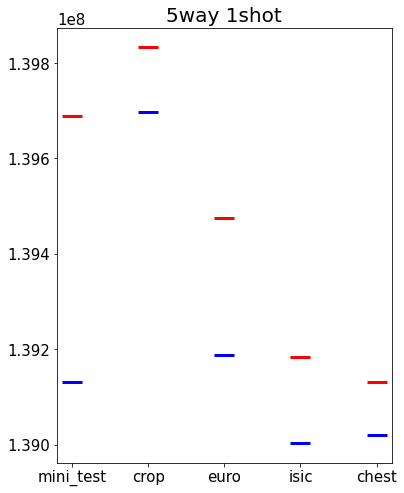

In [182]:
df1 = df.iloc[:,:5].mean(axis=1)
df2 = df.iloc[:,5:].mean(axis=1)
plt.figure(figsize=(6, 8))
plt.plot(df1, '_', color='r', markersize= 20, markeredgewidth='3')
plt.plot(df2, '_', color='b', markersize= 20, markeredgewidth='3')
plt.title("5way 1shot" , fontsize = 20)
plt.show()

In [162]:
datas = ['mini_test', 'crop','euro', 'isic', 'chest']
name = ['best1', 'best2', 'best3', 'best4', 'best5', 'orst1', 'orst2', 'orst3', 'orst4', 'orst5']
df = pd.DataFrame(None, columns = name, index = datas)
for data in df.index: 
    for col in df.columns:
        path_support = './logs/img_ft_difference/feature/{}/pretrained/5shot/{}_x_support.npy'.format(data, col)
        path_query = './logs/img_ft_difference/feature/{}/pretrained/5shot/{}_x_query.npy'.format(data, col)
        f_s = np.load(path_support)
        f_q = np.load(path_query)
        sim = cosine_similarity(f_s, f_q)
        mean_sim = np.empty((0, 75))
        for cls in range(5):
            mean = (sim[cls * 5] + sim[cls * 5 +1] + sim[cls * 5 +2] + sim[cls * 5 +3] + sim[cls * 5 +4])/5
            mean_sim = np.append(mean_sim , mean.reshape(1, -1), axis = 0)
        score = 0
        for cls in range(5):
            idx = cls * 15
            in_class = mean_sim[:, idx:idx+15]
            for i in range(15):
                support = in_class[:,i]
                score = score + support[cls]/np.sum(np.delete(support, 1))
        df.loc[data,col] = math.exp(score)
        
df.columns = ['best1', 'best2', 'best3', 'best4', 'best5', 'worst1', 'worst2', 'worst3', 'worst4', 'worst5']
df

,best1,best2,best3,best4,best5,worst1,worst2,worst3,worst4,worst5
mini_test,139451075.003065,139443817.581909,139628560.747597,139441852.545527,139868936.138413,139313410.09302,139622808.306284,139469847.902319,139139590.151503,138896506.436162
crop,139934537.232767,139963977.193074,139977532.112396,139686586.048072,139988826.647488,139628299.372468,139587752.210858,139421235.53319,139636877.21149,139439245.112877
euro,139596576.357712,139731555.784985,139495937.325088,139386226.995069,139405066.944677,138940125.24285,139188136.162144,139120894.699065,139102892.977752,139013463.404859
isic,139388114.339188,139319638.439854,139285595.270571,139329120.843698,139169027.219133,139003770.65532,139295719.904936,139135657.972227,139177643.989302,138366751.199003
chest,138969008.250219,138985443.197953,139201991.595673,139138451.634056,139037124.007351,138993483.71048,138994256.671827,139008233.026637,138833255.155923,138885419.445682


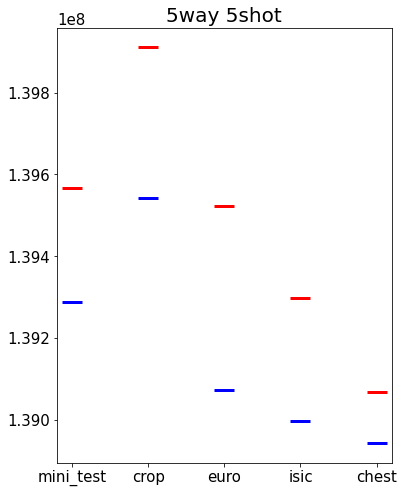

In [180]:
df1 = df.iloc[:,:5].mean(axis=1)
df2 = df.iloc[:,5:].mean(axis=1)
plt.figure(figsize=(6, 8))
plt.plot(df1, '_', color='r', markersize= 20, markeredgewidth='3')
plt.plot(df2, '_', color='b', markersize= 20, markeredgewidth='3')
plt.title("5way 5shot" , fontsize = 20)
plt.show()

In [ ]:
path_support = './logs/img_ft_difference/feature/crop/5shot/best1_x_support.npy'
path_query = './logs/img_ft_difference/feature/crop/5shot/best1_x_query.npy'
f_s = np.load(path_support)
f_q = np.load(path_query)
f_s.shape
f_q.shape

In [ ]:
sim = cosine_similarity(f_s, f_q)

In [ ]:
mean_sim = np.empty((0, 75))
for cls in range(5):
    mean = (sim[cls * 5] + sim[cls * 5 +1] + sim[cls * 5 +2] + sim[cls * 5 +3] + sim[cls * 5 +4])/5
    mean_sim = np.append(mean_sim , mean.reshape(1, -1), axis = 0)
mean_sim.shape

In [ ]:
score = 0
for cls in range(5):
    idx = cls * 15
    in_class = mean_sim[:, idx:idx+15]
    for i in range(15):
        support = in_class[:,i]
        score = score + support[cls]/np.sum(np.delete(support, 1))
print(math.exp(score))

## Image Difference

In [ ]:
samples[0].shape

In [ ]:
# 1 shot
for j, (name, flag) in enumerate(methods.items()):
    df = pd.DataFrame(None, columns = list(range(1, 6)), index = list(range(1, 76)))
    print(name)
    for bw in ['best', 'worst']:
        for rank in range(1, 4):
            path = './logs/baseline/output/resnet10_simclr_LS_default/crop/05way_001shot_head_default/{}{}.txt'.format(bw, rank)
            print(bw, rank)
            with open(path, 'rb') as f:
                test_acc1 = pickle.load(f)
                x_support = pickle.load(f)
                y_support = pickle.load(f)
                x_query = pickle.load(f)
                y_query = pickle.load(f)
            idx = 0
            # query 돌기 0~74
            for q_sample in x_query:
                query = q_sample.cpu().numpy().transpose(1,2,0)
                query_hsv = cv2.cvtColor(query, cv2.COLOR_BGR2HSV)
                query_hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0,180,0, 256])
                query = query_hist
                samples = []
                hists = []
                # support 돌기 0~4
                for sample in x_support:
                    sample_var = sample.cpu().numpy().transpose(1, 2, 0)
                    samples.append(sample_var)
                for i, img in enumerate(samples) :
                    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0,180,0, 256])
                    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
                    hists.append(hist)
                row = []
                for i, (hist, img) in enumerate(zip(hists, samples)):
                    ret = cv2.compareHist(query, hist, flag)
                    row.append(round(ret, 2))
                #print(row)
                #print(row[1:])
                #print(row[0] / sum(row[1:]))

    #             idx = idx + 1
    # print(name)
    # df.to_csv('./logs/img_ft_difference/image/chest/1shot_' + '{}.csv'.format(name), index=False)

In [ ]:
y_query

In [ ]:
# 5shot
for j, (name, flag) in enumerate(methods.items()):
    df = pd.DataFrame(None, columns = list(range(1, 26)), index = list(range(1, 76)))
    for bw in ['best', 'worst']:
        for rank in range(1, 4):
            path = './logs/baseline/output/resnet10_simclr_LS_default/chest/05way_005shot_head_default/{}{}.txt'.format(bw, rank)
            with open(path, 'rb') as f:
                test_acc1 = pickle.load(f)
                x_support = pickle.load(f)
                y_support = pickle.load(f)
                x_query = pickle.load(f)
                y_query = pickle.load(f)
            idx = 0
            for q_sample in x_query:
                query = q_sample.cpu().numpy().transpose(1,2,0)
                query_hsv = cv2.cvtColor(query, cv2.COLOR_BGR2HSV)
                query_hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0,180,0, 256])
                query = query_hist
                samples = []
                hists = []
                for sample in x_support:
                    samples.append(sample.cpu().numpy().transpose(1, 2, 0))
                for i, img in enumerate(samples) :
                    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0,180,0, 256])
                    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
                    hists.append(hist)
                row = []
                for i, (hist, img) in enumerate(zip(hists, samples)):
                    ret = cv2.compareHist(query, hist, flag)
                    row.append(round(ret, 2))
                df.iloc[idx] = row
                idx = idx + 1
    print(name)
    df.to_csv('./logs/img_ft_difference/image/chest/5shot_' + '{}.csv'.format(name), index=False)

In [ ]:
path1 = './logs/baseline/output/resnet10_simclr_LS_default/mini_test/05way_001shot_head_default/best1.txt'
path2 = './logs/baseline/output/resnet10_simclr_LS_default/crop/05way_005shot_head_default/best2.txt'
path3 = './logs/baseline/output/resnet10_simclr_LS_default/crop/05way_005shot_head_default/best3.txt'
with open(path1, 'rb') as f:
    test_acc1 = pickle.load(f)
    x_support = pickle.load(f)
    y_support = pickle.load(f)
    x_query = pickle.load(f)
    y_query = pickle.load(f)
with open(path2, 'rb') as f:
    test_acc2 = pickle.load(f)
    best_img2 = pickle.load(f)
with open(path3, 'rb') as f:
    test_acc3 = pickle.load(f)
    best_img3 = pickle.load(f)

In [ ]:
path = './logs/baseline/output/resnet10_simclr_LS_default/mini_test/05way_001shot_head_default/worst1.txt'
with open(path, 'rb') as f:
    test_acc1 = pickle.load(f)
    x_support = pickle.load(f)
    y_support = pickle.load(f)
    x_query = pickle.load(f)
    y_query = pickle.load(f)

In [ ]:
x_support.shape

In [ ]:
plt.imshow(x_support[4].cpu().permute(1, 2, 0))

In [ ]:
plt.imshow(x_query[70].cpu().permute(1, 2, 0))

In [ ]:
x_support.shape

In [ ]:
query = x_query[70].cpu().numpy().transpose(1, 2, 0)
img1 = x_support[0].cpu().numpy().transpose(1, 2, 0)
img2 = x_support[1].cpu().numpy().transpose(1, 2, 0)
img3 = x_support[2].cpu().numpy().transpose(1, 2, 0)
img4 = x_support[3].cpu().numpy().transpose(1, 2, 0)
img5 = x_support[4].cpu().numpy().transpose(1, 2, 0)

imgs = [img1, img2, img3, img4, img5]
hists = []
for i, img in enumerate(imgs) :
    #---① 각 이미지를 HSV로 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #---② H,S 채널에 대한 히스토그램 계산
    hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0,180,0, 256])
    #---③ 0~1로 정규화
    cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    hists.append(hist)

query_hsv = cv2.cvtColor(query, cv2.COLOR_BGR2HSV)
query_hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0,180,0, 256])
query = query_hist
methods = {'CORREL' :cv2.HISTCMP_CORREL, 'CHISQR':cv2.HISTCMP_CHISQR, 
           'INTERSECT':cv2.HISTCMP_INTERSECT,
           'BHATTACHARYYA':cv2.HISTCMP_BHATTACHARYYA}


for j, (name, flag) in enumerate(methods.items()):
    print('%-10s'%name, end='\t')
    for i, (hist, img) in enumerate(zip(hists, imgs)):
        #---④ 각 메서드에 따라 img1과 각 이미지의 히스토그램 비교
        ret = cv2.compareHist(query, hist, flag)
        if flag == cv2.HISTCMP_INTERSECT: #교차 분석인 경우 
            ret = ret/np.sum(query)        #비교대상으로 나누어 1로 정규화
        print("img%d:%7.2f"% (i+1 , ret), end='\t')
    print()
plt.show()

In [ ]:
for img in x_support:
    plt.imshow(img.cpu().permute(1, 2, 0))

## Loss per iteration

In [ ]:
grad_path = "./logs/experiment/perplexity/resnet10_simclr_LS_default/chest/05way_001shot_head_default/loss_history.csv"
grad_df = pd.read_csv(grad_path, index_col='Unnamed: 0')
plt.xticks(np.arange(-1, 200, 50))
plt.title("Success")
for n_iter in range(0, 3):
    grad_df.iloc[n_iter,:].plot()
    plt.ylim(-0.1, 4)
plt.show()

plt.xticks(np.arange(-1, 200, 50))
plt.title("Fail")
for n_iter in range(3, 6):
    grad_df.iloc[n_iter,:].plot()
    plt.ylim(-0.1, 4)
plt.show()

In [ ]:
grad_path = "./logs/experiment/perplexity/resnet10_simclr_LS_default/chest/05way_005shot_head_default/loss_history.csv"
grad_df = pd.read_csv(grad_path, index_col='Unnamed: 0')
plt.xticks(np.arange(-1, 700, 100))
plt.title("Success")
for n_iter in range(0, 3):
    grad_df.iloc[n_iter,:].plot()
    plt.ylim(-0.1, 4)
plt.show()

plt.xticks(np.arange(-1, 700, 100))
plt.title("Fail")
for n_iter in range(3, 6):
    grad_df.iloc[n_iter,:].plot()
    plt.ylim(-0.1, 4)
plt.show()

오 차이 절대 없어~

## Gradient L2 Norm

In [ ]:
grad_path = "./logs/experiment/perplexity/resnet10_simclr_LS_default/chest/05way_001shot_head_default/grad_history.csv"
grad_df = pd.read_csv(grad_path, index_col='Unnamed: 0')
plt.xticks(np.arange(-1, 200, 50))
plt.title("Success")
for n_iter in range(0, 3):
    grad_df.iloc[n_iter,:].plot()
    plt.ylim(-0.1, 20)
plt.show()

plt.title("Fail")
plt.xticks(np.arange(-1, 200, 50))
for n_iter in range(3, 6):
    grad_df.iloc[n_iter,:].plot()
    plt.ylim(-0.1, 20)
plt.show()

In [ ]:
grad_path = "./logs/experiment/perplexity/resnet10_simclr_LS_default/isic/05way_005shot_head_default/grad_history.csv"
grad_df = pd.read_csv(grad_path, index_col='Unnamed: 0')
plt.xticks(np.arange(-1, 700, 100))
plt.title("Success")
for n_iter in range(0, 3):
    grad_df.iloc[n_iter,:].plot()
    plt.ylim(-0.1, 20)
plt.show()

plt.title("Fail")
plt.xticks(np.arange(-1, 700, 100))
for n_iter in range(3, 6):
    grad_df.iloc[n_iter,:].plot()
    plt.ylim(-0.1, 20)
plt.show()

In [ ]:
grad_df